In [1]:
from pandas.errors import EmptyDataError
import pandas as pd
import os 
import glob 

csv_files = glob.glob(os.path.join("results/", "*.csv")) 
  
dfs = []
for f in csv_files:       
    try:
        df = pd.read_csv(f)
        if len(df) > 0:
            df['layer'] = df['name'].index + 1 
            df['last'] = 'last' in f 
            dfs.append(df)
    except EmptyDataError:
        continue
        
df = pd.concat(dfs, ignore_index=True)

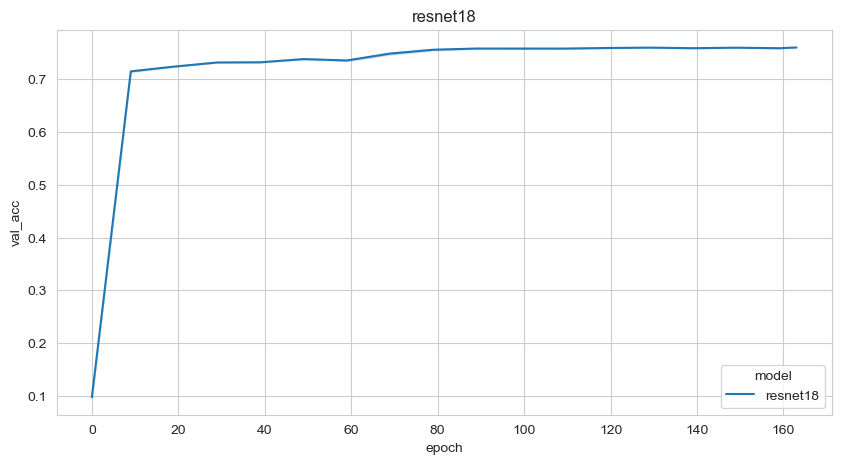

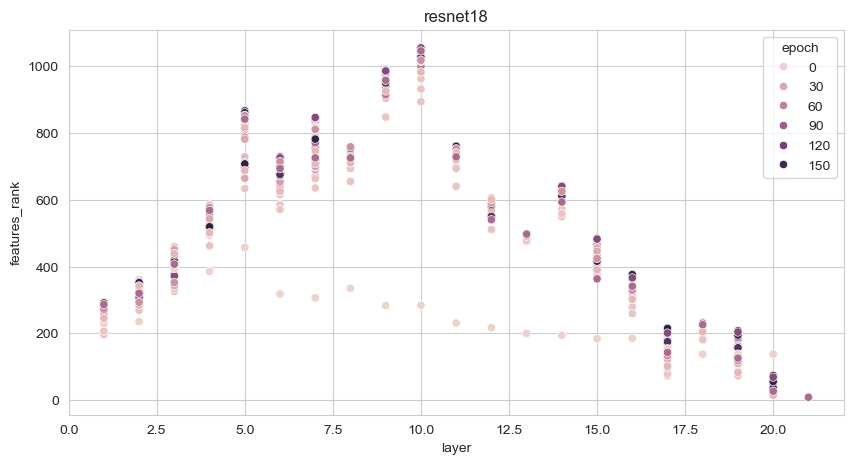

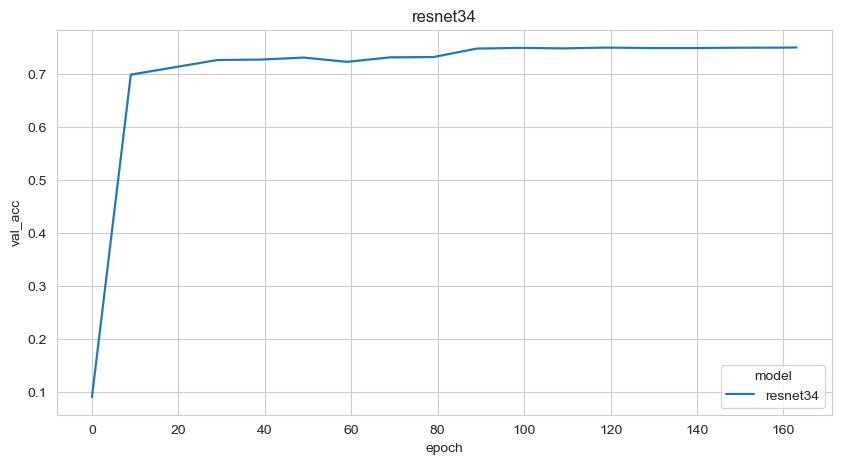

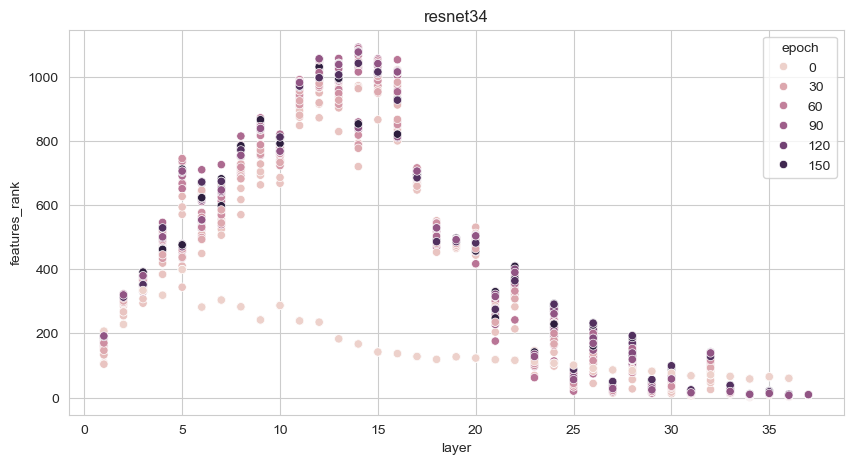

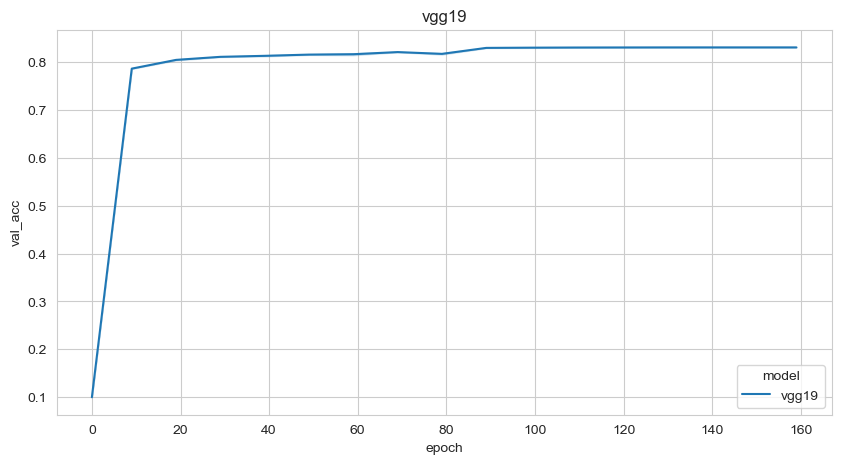

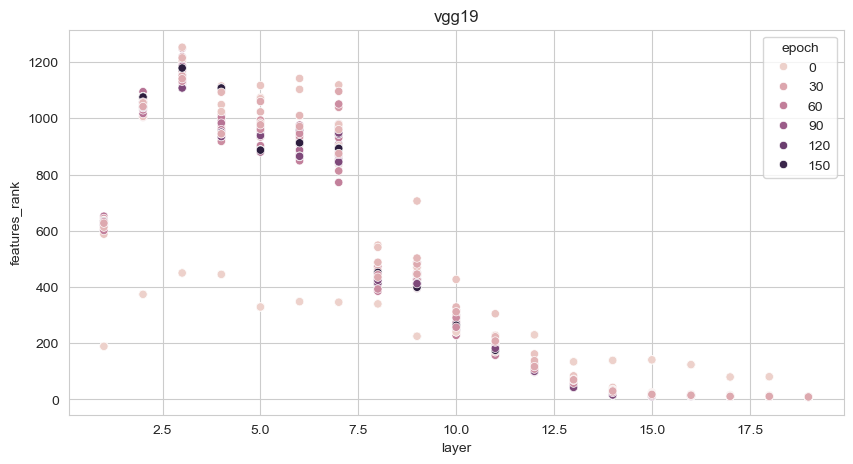

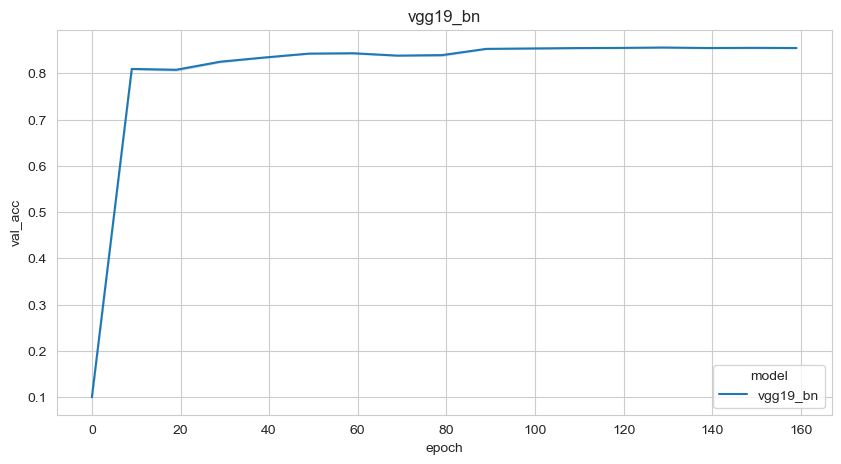

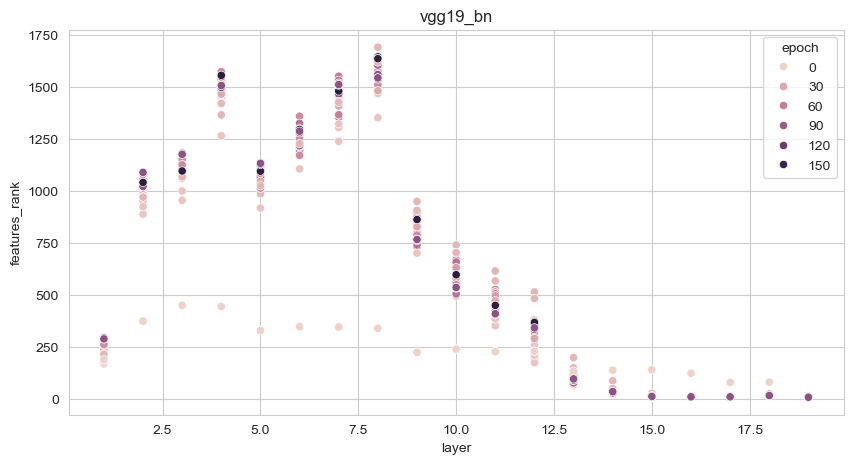

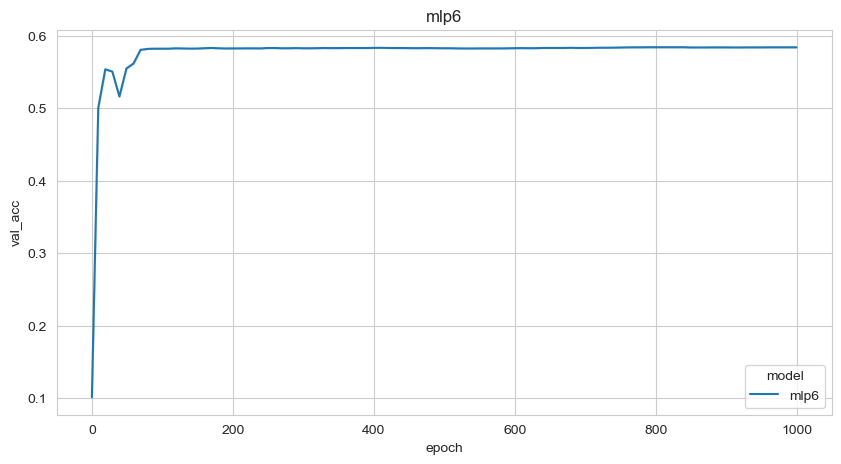

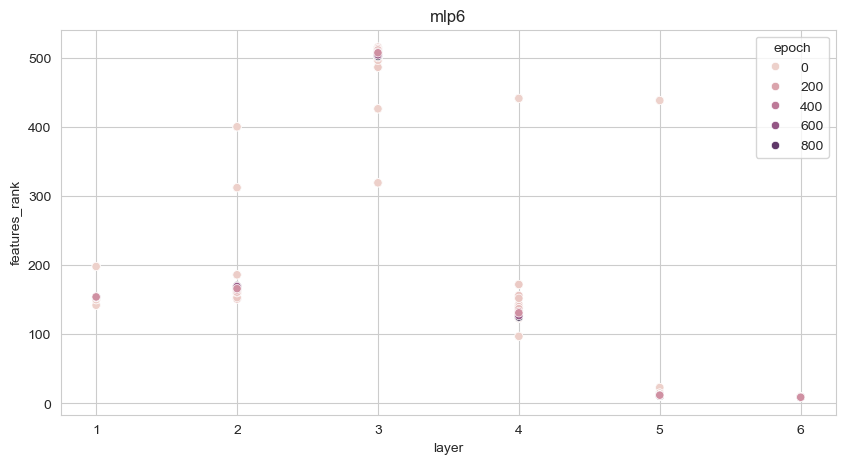

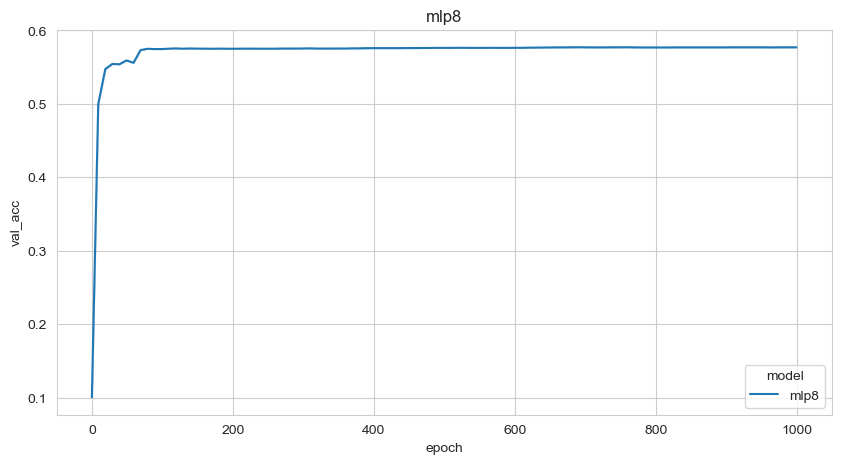

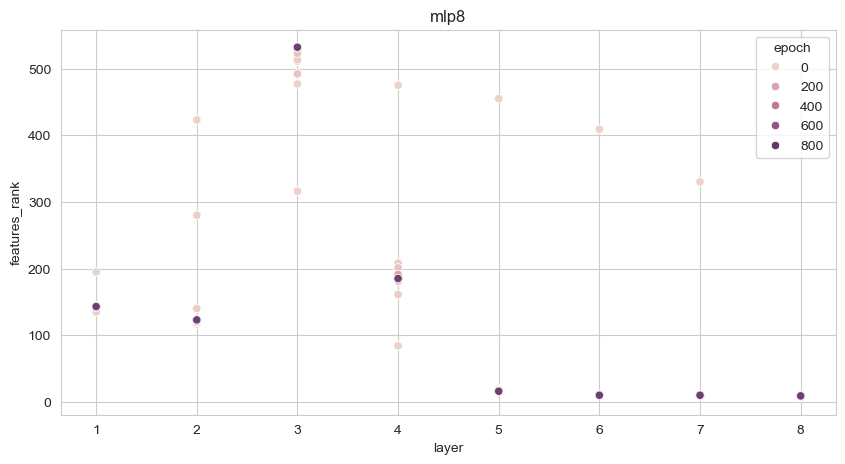

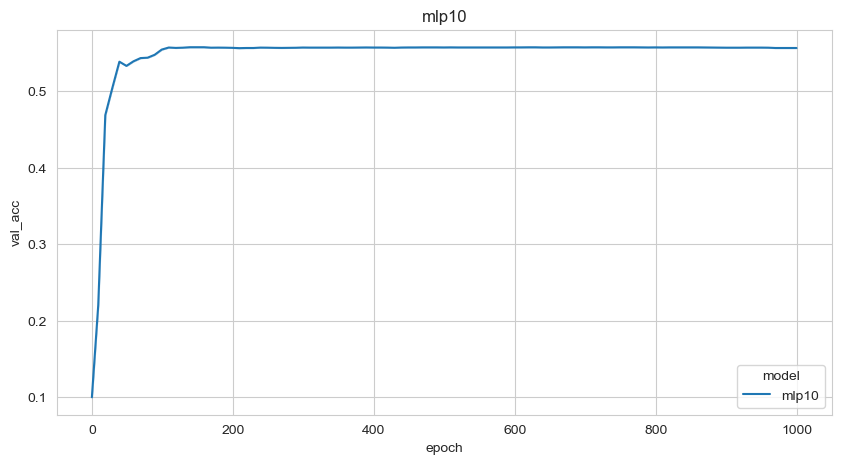

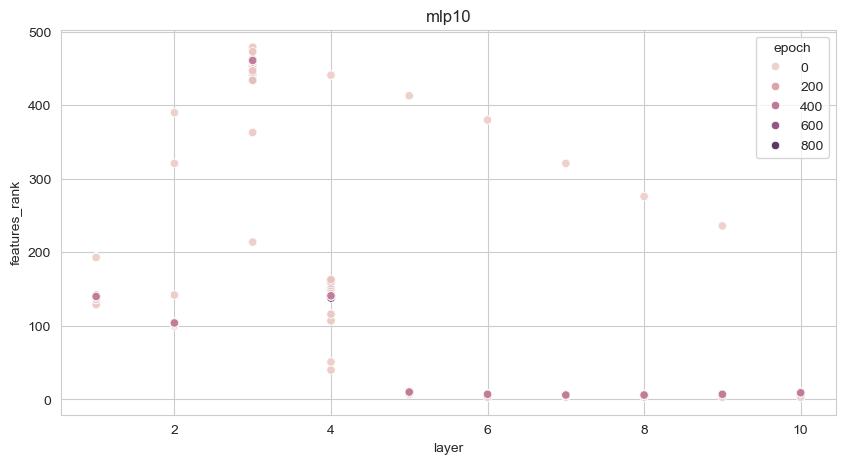

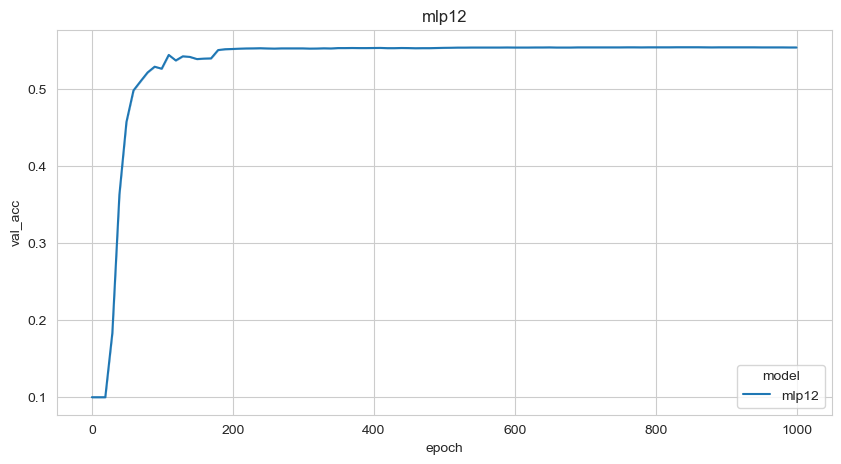

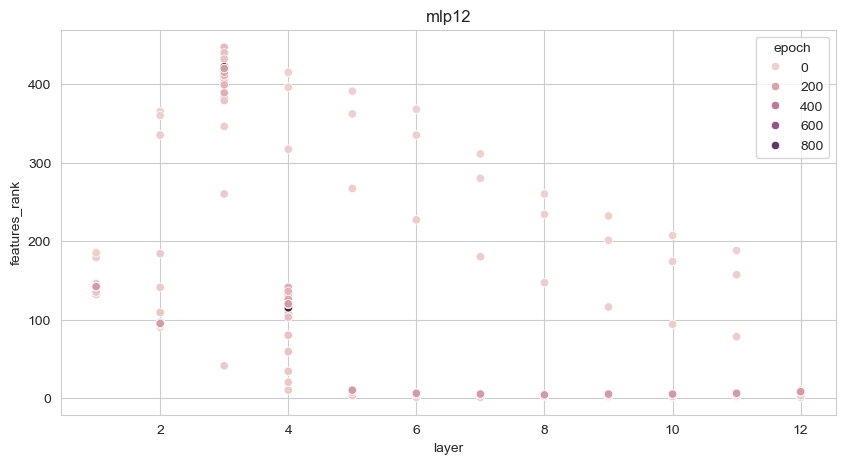

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

for model in ['resnet18', 'resnet34', 'vgg19', 'vgg19_bn', 'mlp6', 'mlp8', 'mlp10', 'mlp12']:
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10')]
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.lineplot(x="epoch", y="val_acc", hue="model", data=df2)
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.scatterplot(x="layer", y="features_rank", hue='epoch', data=df2)


In [3]:
df2[df2['name']=='features.0']

,Unnamed: 0,name,output,model,dataset,lr,seed,epoch,val_acc,features_rank,features_dim,normalized_features_rank,weights_rank,layer,last


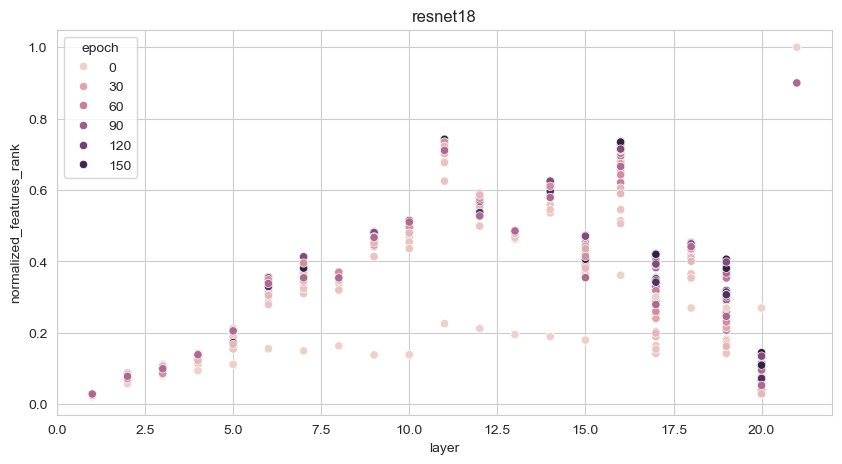

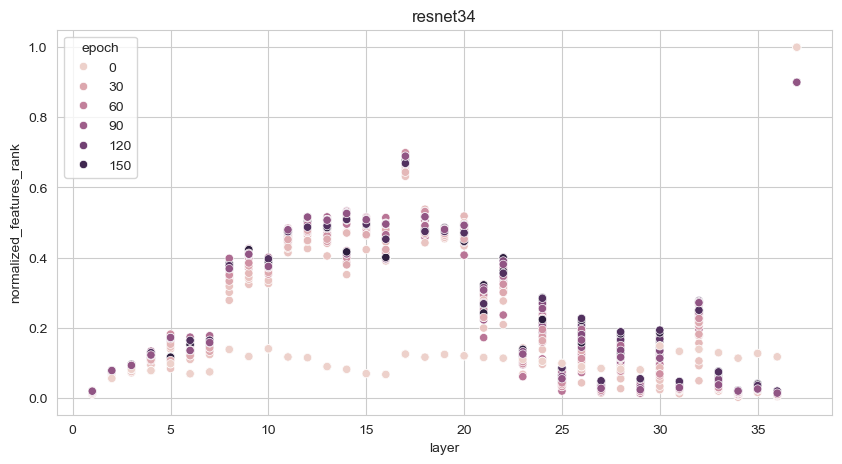

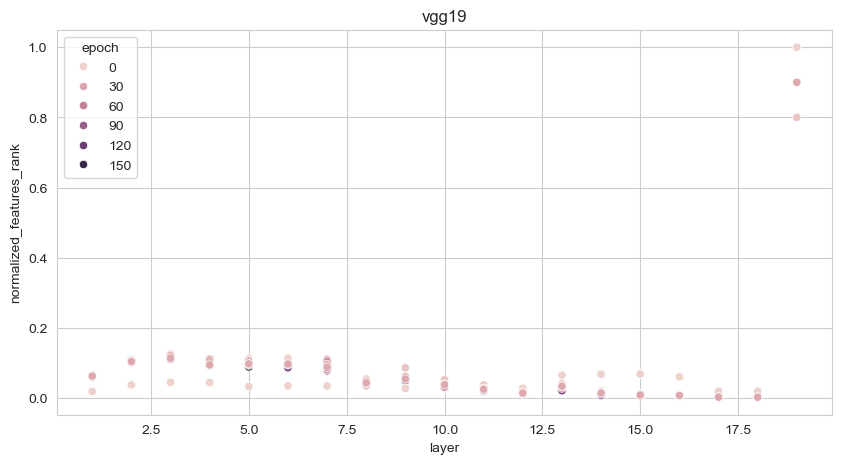

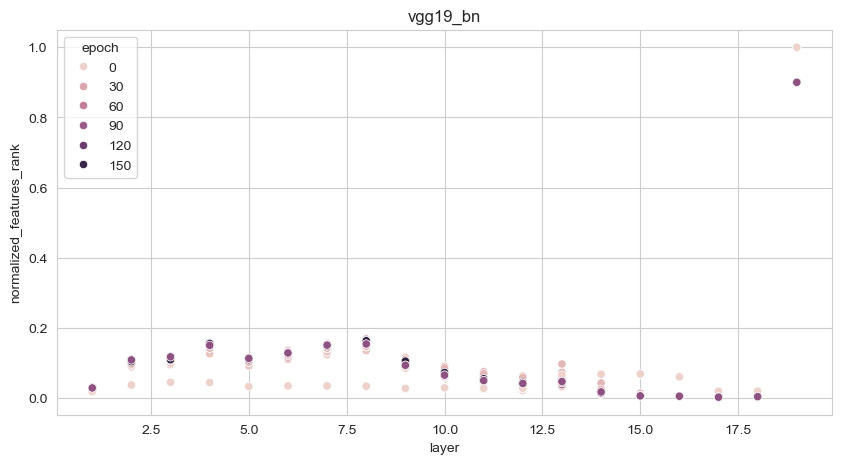

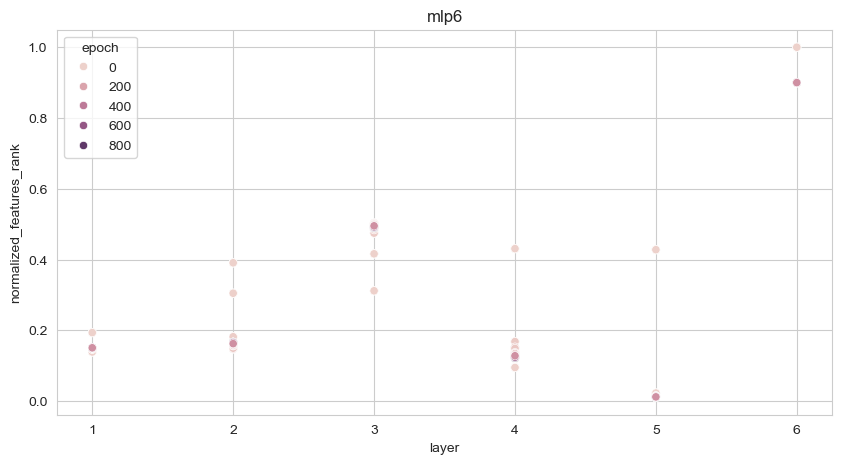

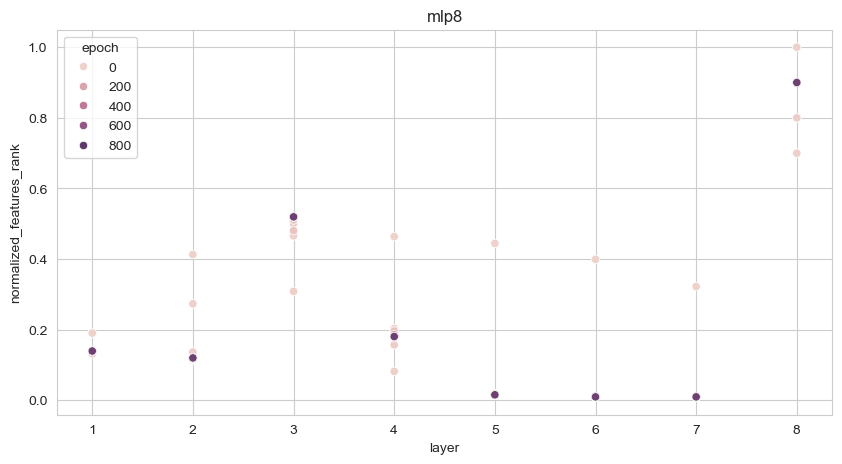

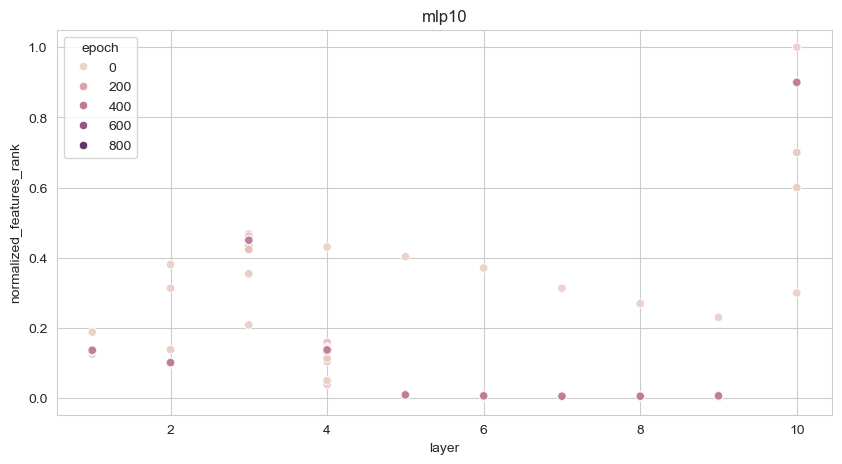

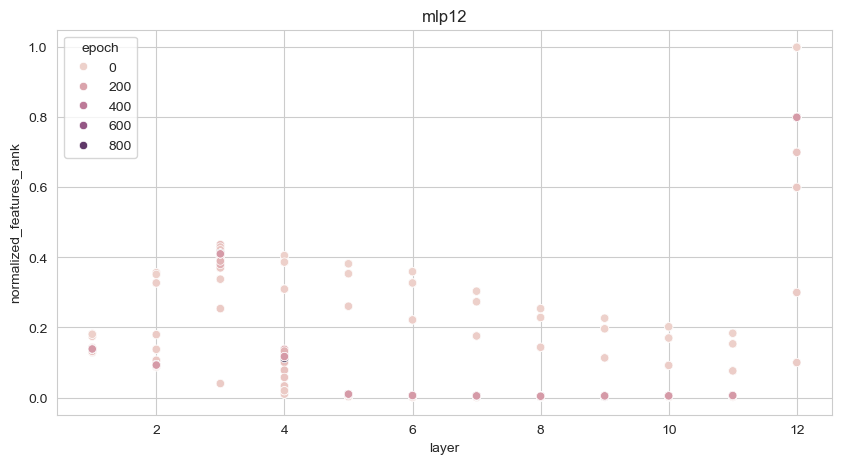

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

for model in ['resnet18', 'resnet34', 'vgg19', 'vgg19_bn', 'mlp6', 'mlp8', 'mlp10', 'mlp12']:
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10')]
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.scatterplot(x="layer", y="normalized_features_rank", hue='epoch', data=df2)


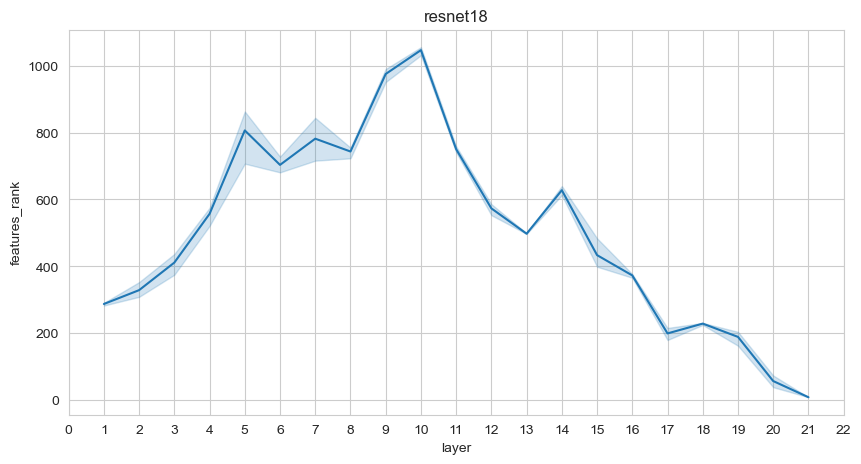

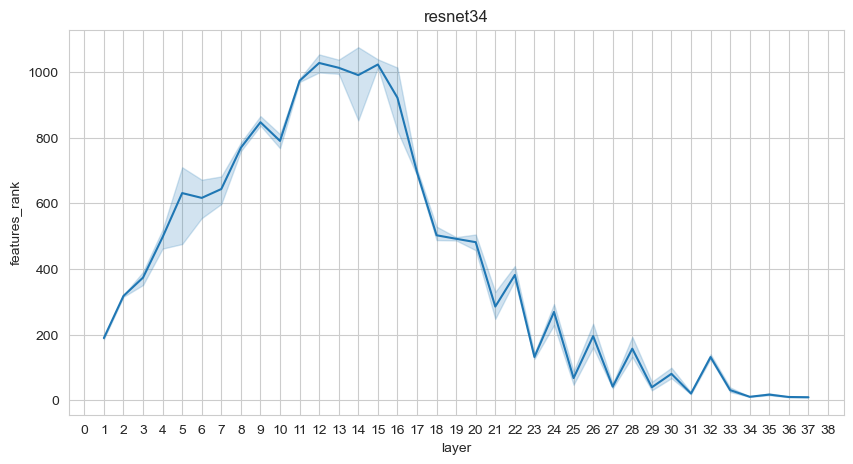

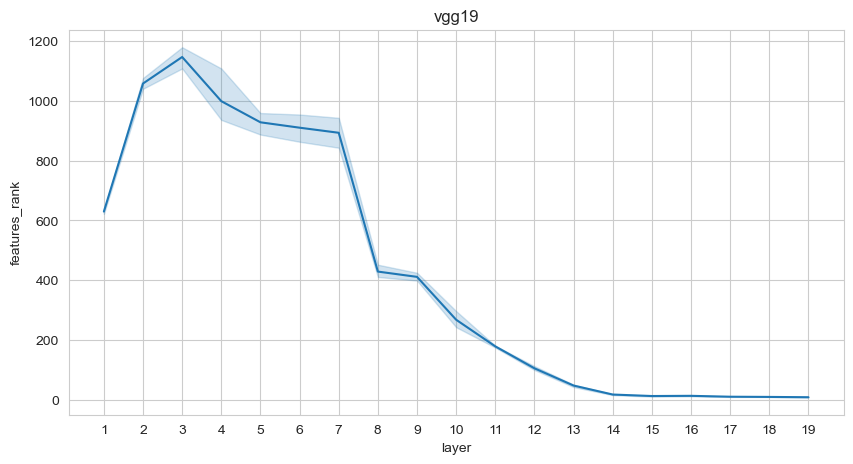

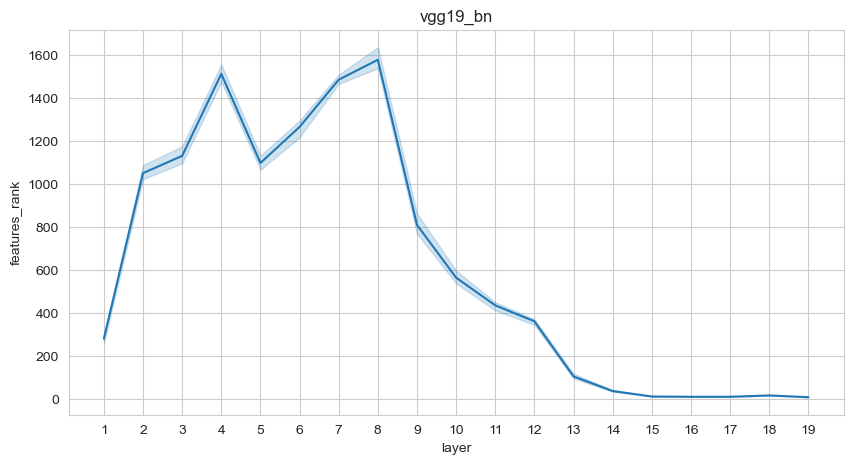

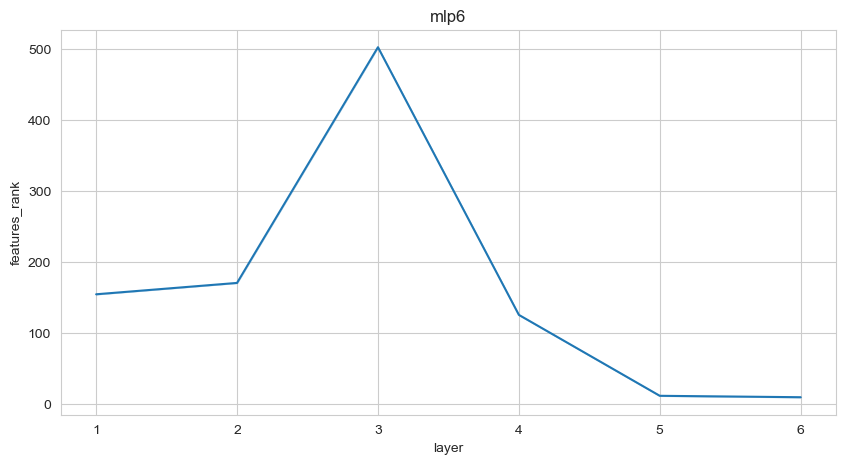

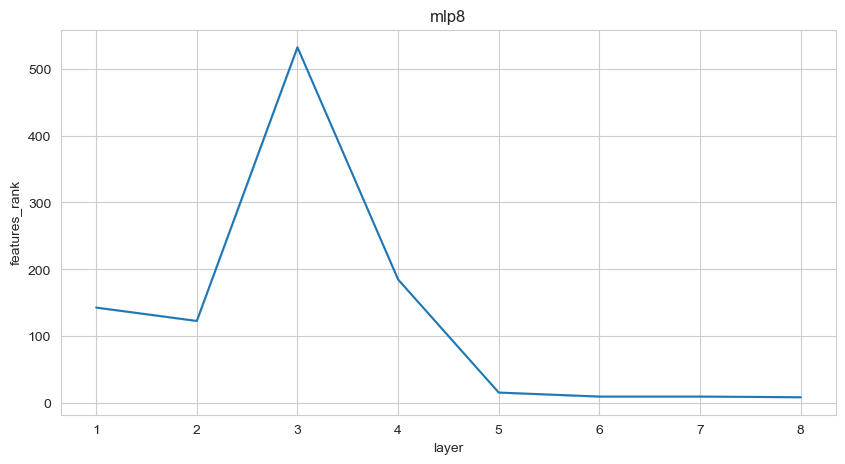

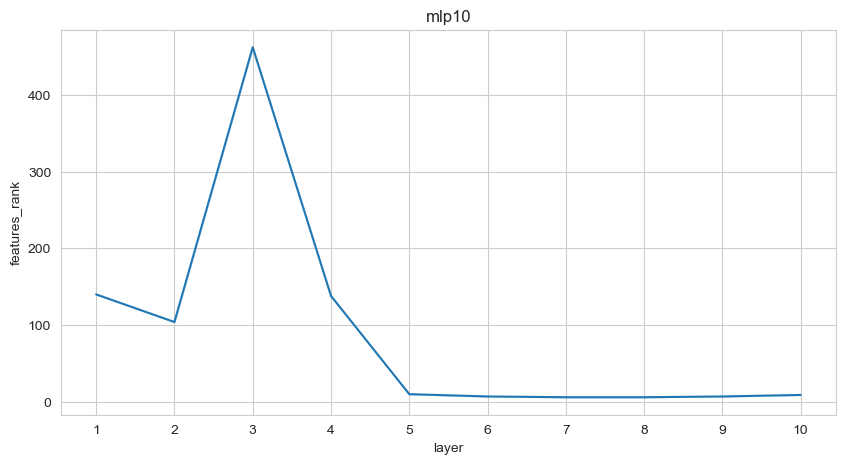

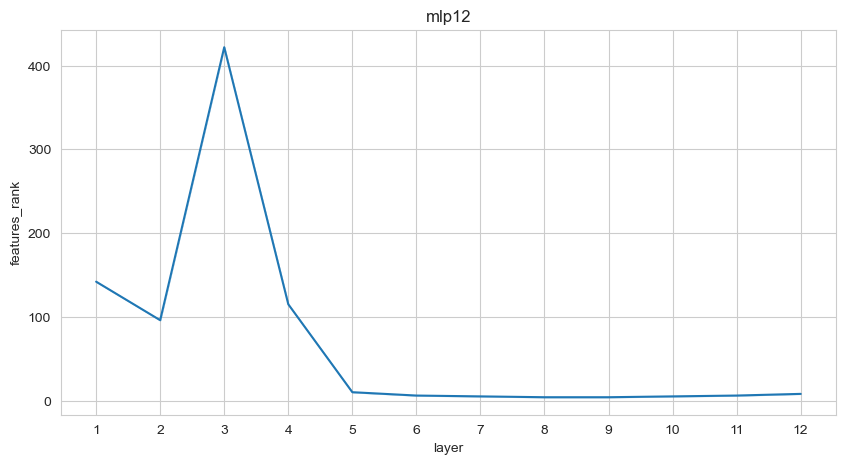

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19', 'vgg19_bn', 'mlp6', 'mlp8', 'mlp10', 'mlp12']:
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10') & df['last']]
    
    plt.figure(figsize = (10,5))
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    plt.gca().xaxis.set_major_locator(loc)
    plt.title(model)
    sns.lineplot(x="layer", y="features_rank", data=df2)


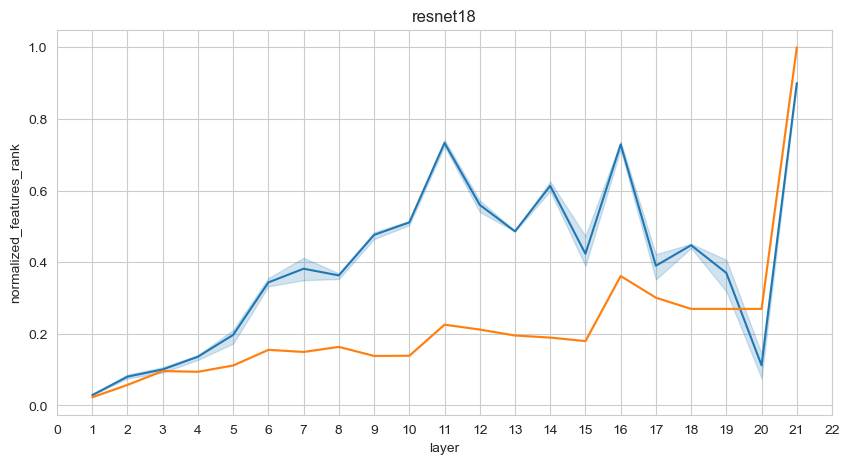

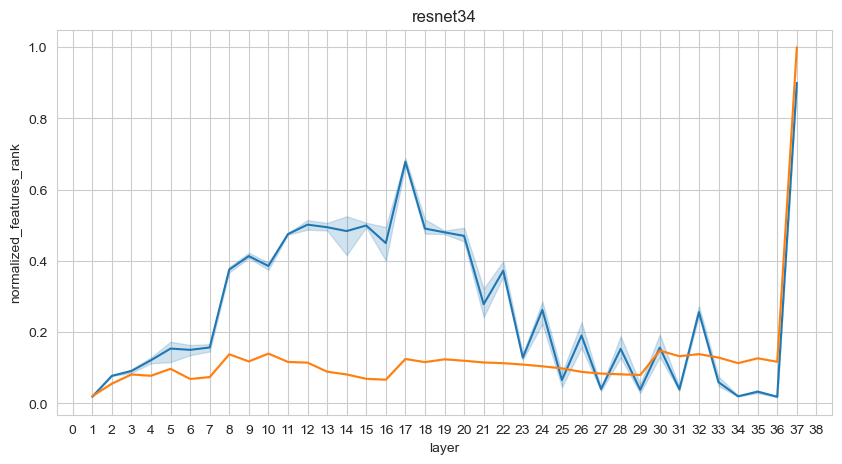

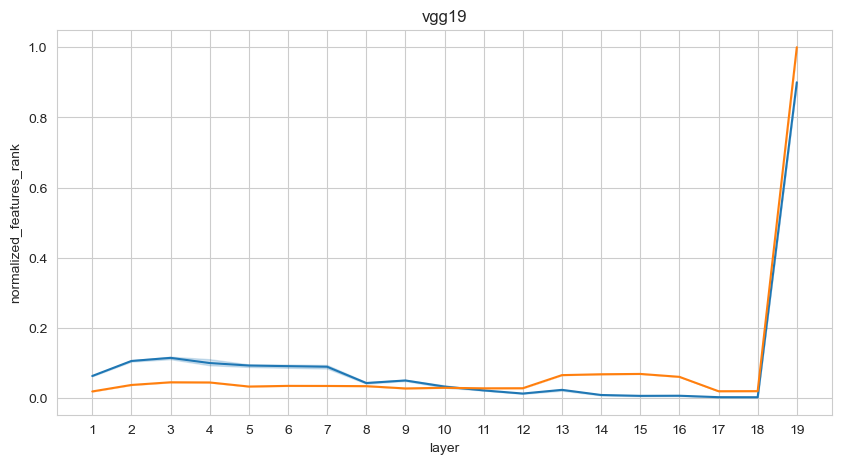

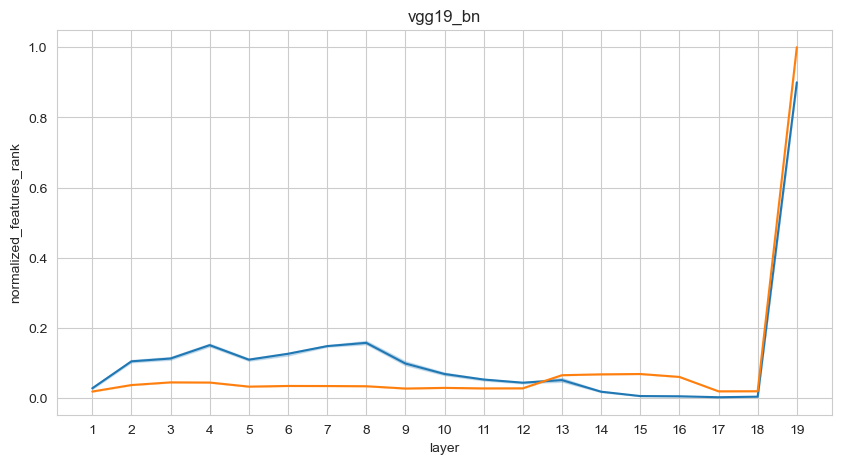

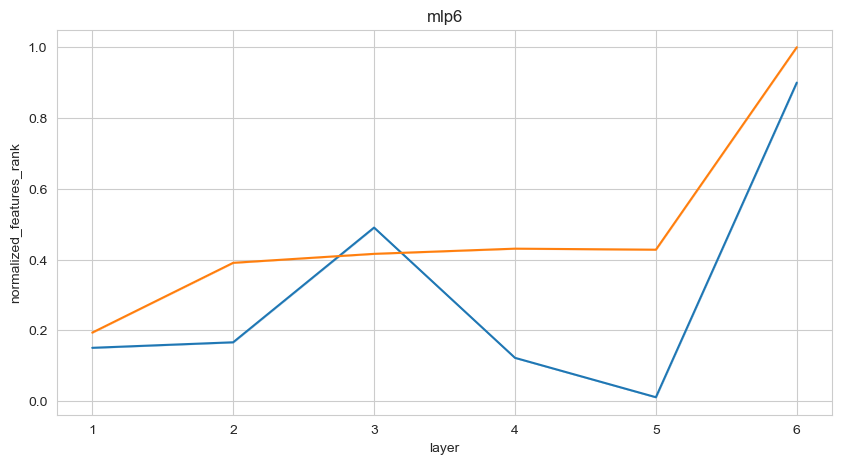

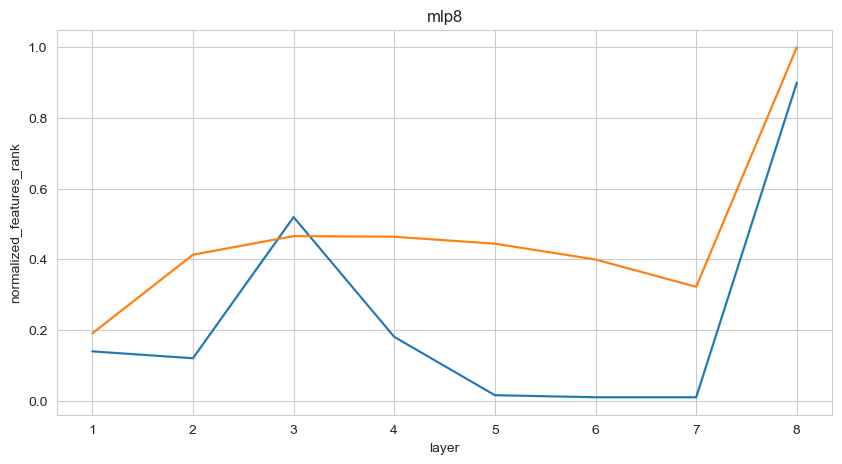

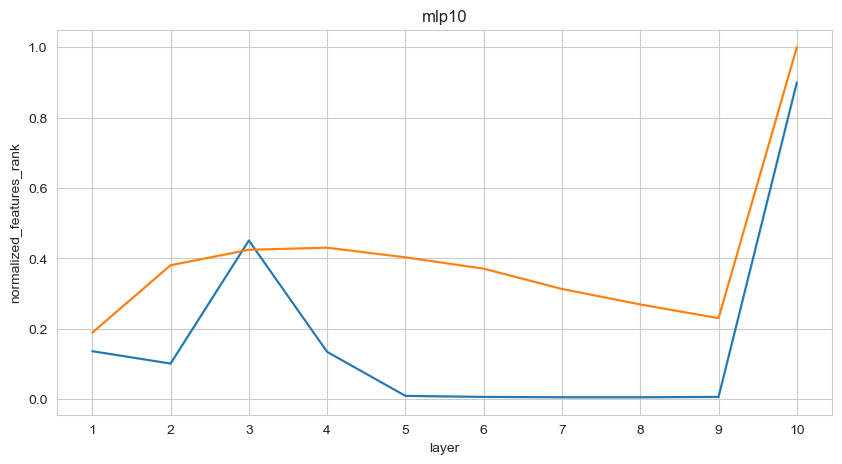

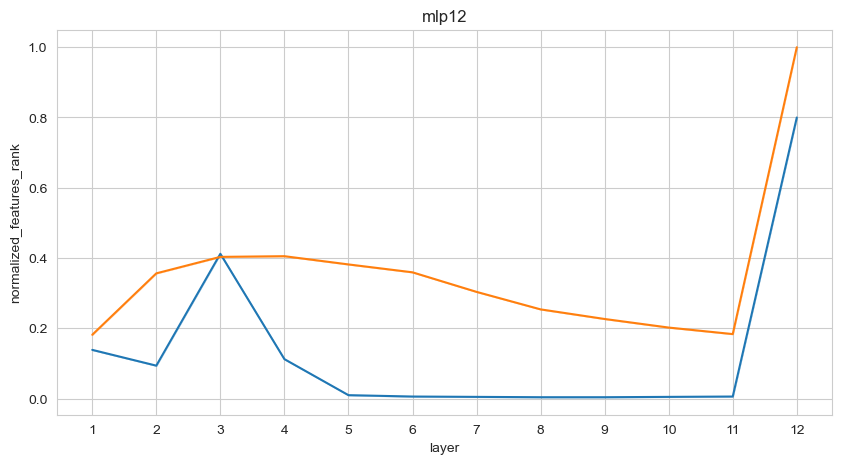

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19', 'vgg19_bn', 'mlp6', 'mlp8', 'mlp10', 'mlp12']:
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10') & df['last']]
    
    plt.figure(figsize = (10,5))
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    plt.gca().xaxis.set_major_locator(loc)
    plt.title(model)
    sns.lineplot(x="layer", y="normalized_features_rank", data=df2)
    
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10') & (df['epoch']==0)]
    sns.lineplot(x="layer", y="normalized_features_rank", data=df2)

In [7]:
df[(df['model']=='vgg19') & (df['lr']<0.1) & (df['dataset']=='cifar10') & (df['epoch']==0) & (df['name']=='features.0')]

,Unnamed: 0,name,output,model,dataset,lr,seed,epoch,val_acc,features_rank,features_dim,normalized_features_rank,weights_rank,layer,last
2279,0,features.0,/ssd/tunnel/models,vgg19,cifar10,0.01,2,0,0.1,189,65536,0.0189,27,1,False
16798,0,features.0,/ssd/tunnel/models,vgg19,cifar10,0.01,1,0,0.1,189,65536,0.0189,27,1,False
20044,0,features.0,/ssd/tunnel/models,vgg19,cifar10,0.01,0,0,0.1,189,65536,0.0189,27,1,False


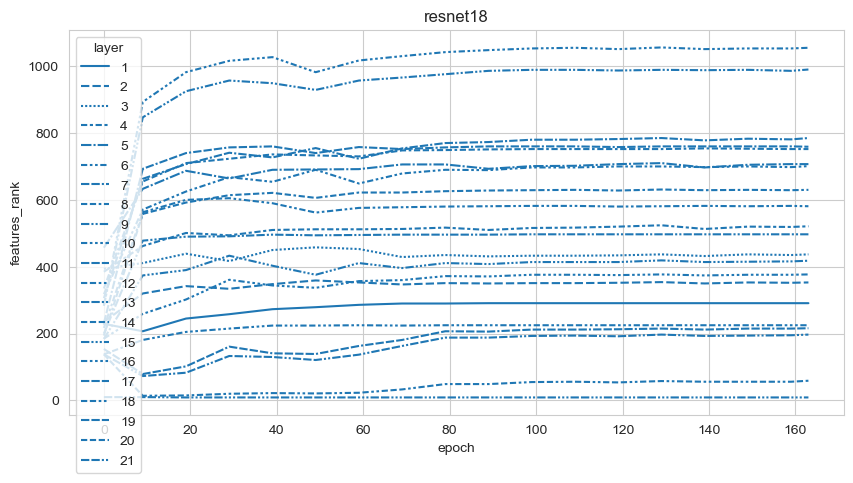

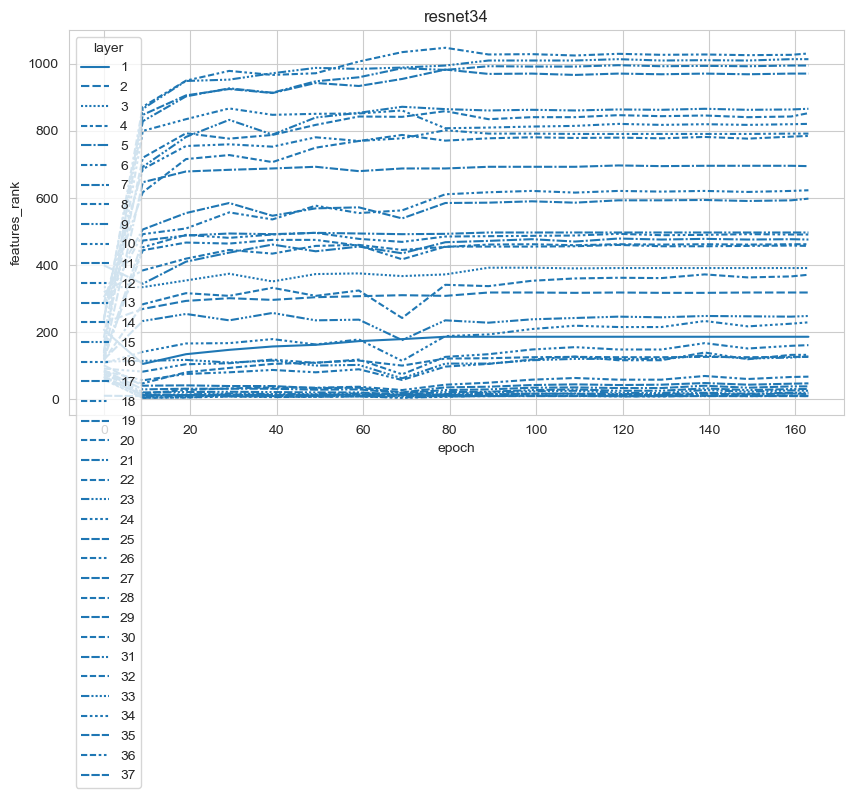

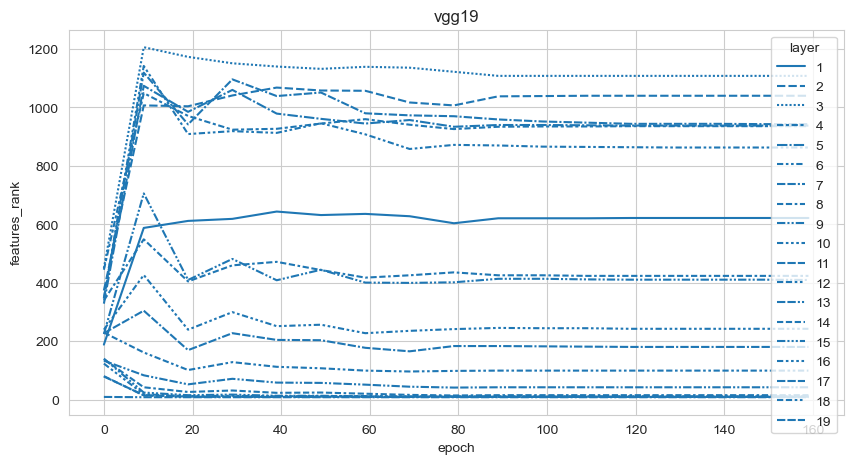

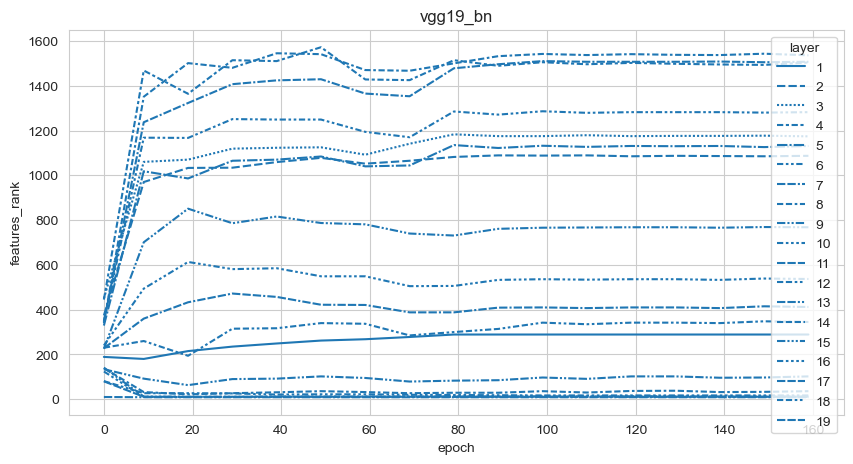

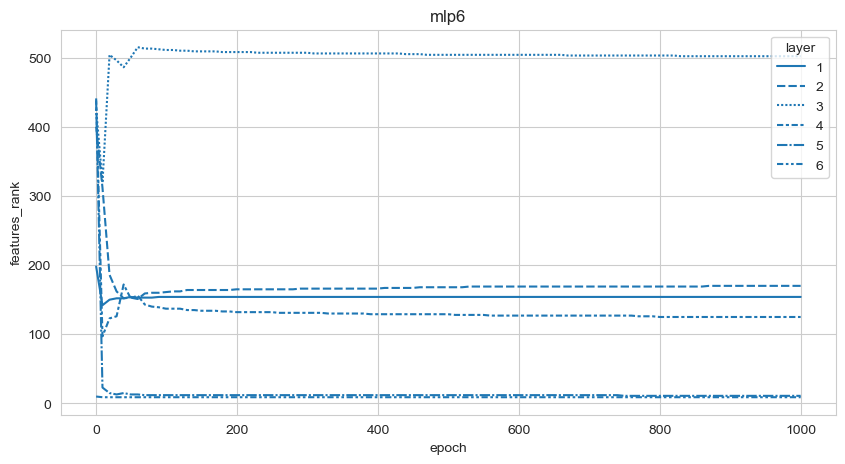

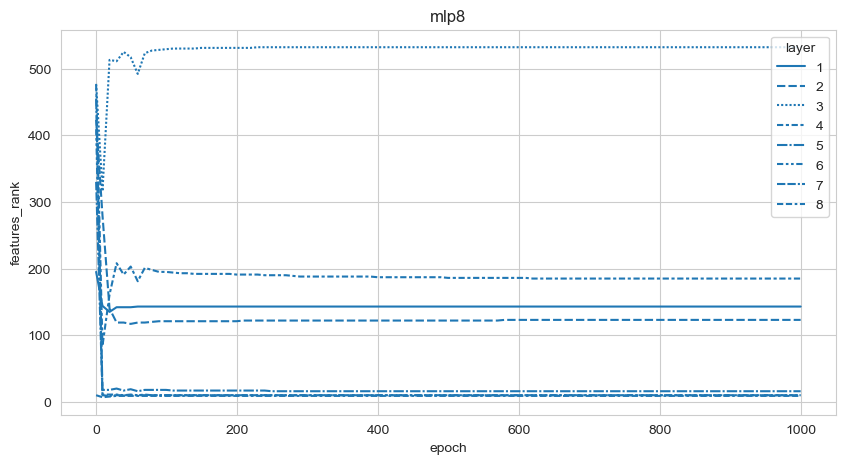

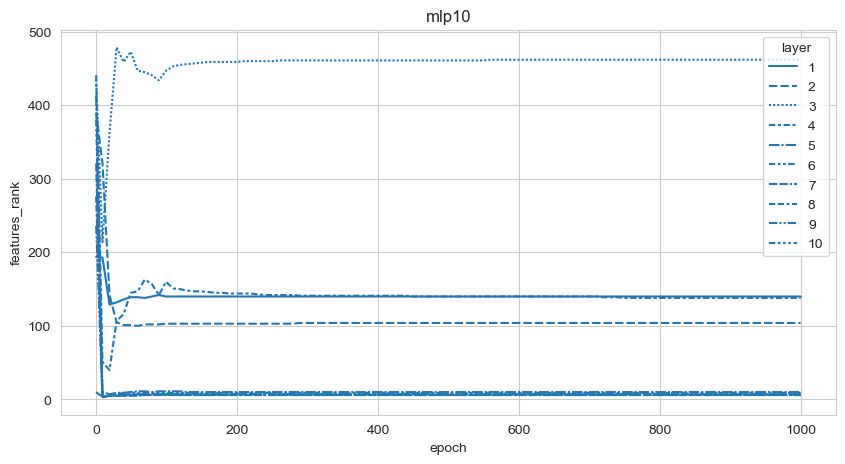

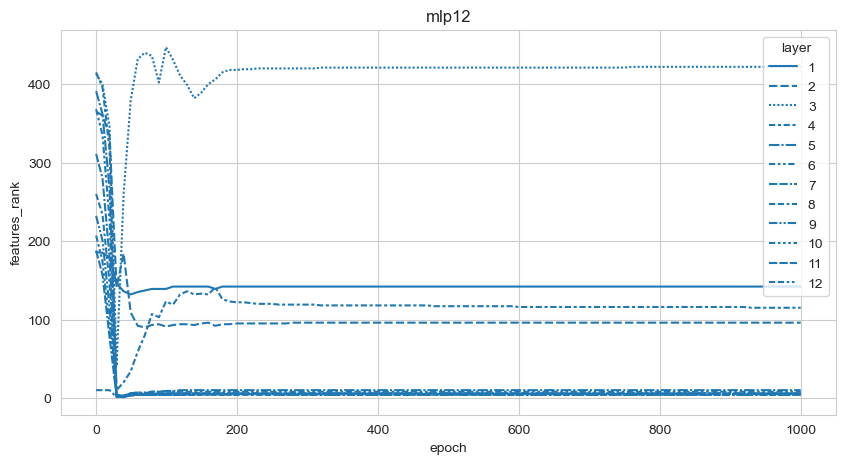

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

for model in ['resnet18', 'resnet34', 'vgg19', 'vgg19_bn', 'mlp6', 'mlp8', 'mlp10', 'mlp12']:
    df2 = df[(df['model']==model) & (df['lr']<0.1) & (df['dataset']=='cifar10') & (df['seed']==0)]
    
    plt.figure(figsize = (10,5))
    plt.title(model)
    sns.lineplot(x="epoch", y="features_rank", data=df2, style='layer')